In [52]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import re
sns.set()

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import train_test_split
import matplotlib as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import lars_path
%pylab inline
import patsy
import scipy.stats as stats
%matplotlib inline


headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9'}

Populating the interactive namespace from numpy and matplotlib


C:\Users\alawe_000\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [53]:
url = 'https://www.amazon.com/best-sellers-video-games/zgbs/videogames/ref=zg_bs_nav_0'

response=requests.get(url,headers=headers)
#response = requests.get(url)
response.status_code


200

In [54]:
page = response.text

In [55]:
soup = BeautifulSoup(page, "lxml")

In [56]:
def clean_num(s):
    

    if s is None:
        return s
    return "".join(re.findall('\d*\.?\d+',s))

def get_data(block, tag, class_text):
    try:
        return block.find(tag, class_ = class_text).text
    except AttributeError:
        return ""
    return

In [57]:
for i in (soup.find("li", "zg-item-immersion")):
    print(str.strip(get_data(i, "div", "p13n-sc-truncate")))
    print(get_data(i, "div", "a-row a-size-small"))
    print(clean_num(get_data(i, "span", "a-size-small a-color-base").split(" ")[0]))
    print(get_data(i, "a","a-size-small a-link-normal"))
    print(clean_num(get_data(i, "a","a-size-small a-link-normal")))
    print(get_data(i, "span","p13n-sc-price"))
    print(clean_num(get_data(i, "span", "p13n-sc-price")))

$10 PlayStation Store Gift Card [Digital Code]
PlayStation

248,158
248158
$10.00
10.00


In [58]:
VideoGames_list = []
for i in (soup.find_all("li", class_ = "zg-item-immersion")):
    type = str.strip(get_data(i, "div", "p13n-sc-truncate"))
    company = get_data(i, True, ["a-row a-size-small", "a-size-small a-color-base"])
    #rating = get_data(i, "span", "a-icon-alt")
    rating = clean_num(get_data(i, "span", "a-icon-alt").split(" ")[0]) 
    #review_num = get_data(i, "a","a-size-small a-link-normal")
    review_num = clean_num(get_data(i, "a","a-size-small a-link-normal"))
    #price = get_data(i, "span","p13n-sc-price")
    price= clean_num(get_data(i, "span", "p13n-sc-price"))
    
    headers = ['VideoGamesType', 'company', 'rating','review_num',
              'price',]
    VideoGames_list_dict = dict(zip(headers, [ type,
                                    company,
                                    rating,
                                    review_num, 
                                    price]))
    VideoGames_list.append(VideoGames_list_dict)


In [59]:
VideoGames_list

[{'VideoGamesType': '$10 PlayStation Store Gift Card [Digital Code]',
  'company': 'PlayStation',
  'rating': '4.7',
  'review_num': '248158',
  'price': '10.00'},
 {'VideoGamesType': '$10 Xbox Gift Card [Digital Code]',
  'company': 'Microsoft',
  'rating': '4.7',
  'review_num': '127302',
  'price': '10.00'},
 {'VideoGamesType': '$10 Nintendo eShop Gift Card [Digital Code]',
  'company': 'Nintendo',
  'rating': '4.7',
  'review_num': '73481',
  'price': '5.00'},
 {'VideoGamesType': 'Roblox Gift Card - 800 Robux [Includes Exclusive Virtual Item] [Online Game Code]',
  'company': 'Roblox',
  'rating': '4.6',
  'review_num': '79974',
  'price': '10.00'},
 {'VideoGamesType': 'Roblox Gift Card - 2000 Robux [Includes Exclusive Virtual Item] [Online Game Code]',
  'company': 'Roblox',
  'rating': '4.6',
  'review_num': '79974',
  'price': '25.00'},
 {'VideoGamesType': 'Oculus Quest 2 — Advanced All-In-One Virtual Reality Headset — 128 GB',
  'company': 'Oculus',
  'rating': '4.6',
  'review

In [60]:
#convert list of dict to df
VideoGames_df = pd.DataFrame(VideoGames_list).replace("",np.nan)  
VideoGames_df.head()

,VideoGamesType,company,rating,review_num,price
0,$10 PlayStation Store Gift Card [Digital Code],PlayStation,4.7,248158,10.00
1,$10 Xbox Gift Card [Digital Code],Microsoft,4.7,127302,10.00
2,$10 Nintendo eShop Gift Card [Digital Code],Nintendo,4.7,73481,5.00
3,Roblox Gift Card - 800 Robux [Includes Exclusi...,Roblox,4.6,79974,10.00
4,Roblox Gift Card - 2000 Robux [Includes Exclus...,Roblox,4.6,79974,25.00


In [61]:
VideoGames_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   VideoGamesType  50 non-null     object
 1   company         39 non-null     object
 2   rating          46 non-null     object
 3   review_num      46 non-null     object
 4   price           43 non-null     object
dtypes: object(5)
memory usage: 2.1+ KB


In [62]:
VideoGames_df.isna().sum()

VideoGamesType     0
company           11
rating             4
review_num         4
price              7
dtype: int64

In [63]:
VideoGames_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   VideoGamesType  50 non-null     object
 1   company         39 non-null     object
 2   rating          46 non-null     object
 3   review_num      46 non-null     object
 4   price           43 non-null     object
dtypes: object(5)
memory usage: 2.1+ KB


In [64]:
headers = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2) AppleWebKit/601.3.9 (KHTML, like Gecko) Version/9.0.2 Safari/601.3.9'}

In [65]:
url2='https://www.amazon.com/best-sellers-video-games/zgbs/videogames/ref=zg_bs_pg_2?_encoding=UTF8&pg=2'
response=requests.get(url2,headers=headers)
#response = requests.get(url2)
response.status_code


200

In [66]:
page_2 = response.text

In [67]:
soup = BeautifulSoup(page_2, "lxml")

In [68]:
def clean_num(s):
    

    if s is None:
        return s
    return "".join(re.findall('\d*\.?\d+',s))

def get_data(block, tag, class_text):
    try:
        return block.find(tag, class_ = class_text).text
    except AttributeError:
        return ""
    return

In [69]:
for i in (soup.find("li", "zg-item-immersion")):
    print(str.strip(get_data(i, "div", "p13n-sc-truncate")))
    print(get_data(i, "div", "a-row a-size-small"))
    print(clean_num(get_data(i, "span", "a-size-small a-color-base").split(" ")[0]))
    print(get_data(i, "a","a-size-small a-link-normal"))
    print(clean_num(get_data(i, "a","a-size-small a-link-normal")))
    print(get_data(i, "span","p13n-sc-price"))
    print(clean_num(get_data(i, "span", "p13n-sc-price")))

Super Mario 3D World + Bowser's Fury - Nintendo Switch
Nintendo

20,317
20317




In [70]:
VideoGames_list1 = []
for i in (soup.find_all("li", class_ = "zg-item-immersion")):
    type = str.strip(get_data(i, "div", "p13n-sc-truncate"))
    company = get_data(i, True, ["a-row a-size-small", "a-size-small a-color-base"])
    #rating = get_data(i, "span", "a-icon-alt")
    rating = clean_num(get_data(i, "span", "a-icon-alt").split(" ")[0]) 
    #review_num = get_data(i, "a","a-size-small a-link-normal")
    review_num = clean_num(get_data(i, "a","a-size-small a-link-normal"))
    #price = get_data(i, "span","p13n-sc-price")
    price= clean_num(get_data(i, "span", "p13n-sc-price"))
    
    headers = ['VideoGamesType', 'company', 'rating','review_num',
              'price',]
    VideoGames_list1_dict = dict(zip(headers, [ type,
                                    company,
                                    rating,
                                    review_num, 
                                    price]))
    VideoGames_list1.append(VideoGames_list_dict)


In [71]:
VideoGames_list1

[{'VideoGamesType': 'PlayStation Plus: 12 Month Membership [Digital Code]',
  'company': 'PlayStation',
  'rating': '4.8',
  'review_num': '47081',
  'price': '59.99'},
 {'VideoGamesType': 'PlayStation Plus: 12 Month Membership [Digital Code]',
  'company': 'PlayStation',
  'rating': '4.8',
  'review_num': '47081',
  'price': '59.99'},
 {'VideoGamesType': 'PlayStation Plus: 12 Month Membership [Digital Code]',
  'company': 'PlayStation',
  'rating': '4.8',
  'review_num': '47081',
  'price': '59.99'},
 {'VideoGamesType': 'PlayStation Plus: 12 Month Membership [Digital Code]',
  'company': 'PlayStation',
  'rating': '4.8',
  'review_num': '47081',
  'price': '59.99'},
 {'VideoGamesType': 'PlayStation Plus: 12 Month Membership [Digital Code]',
  'company': 'PlayStation',
  'rating': '4.8',
  'review_num': '47081',
  'price': '59.99'},
 {'VideoGamesType': 'PlayStation Plus: 12 Month Membership [Digital Code]',
  'company': 'PlayStation',
  'rating': '4.8',
  'review_num': '47081',
  'pric

In [72]:
#convert list of dict to df
VideoGames_df2 = pd.DataFrame(VideoGames_list1).replace("",np.nan)  
VideoGames_df2.head()

,VideoGamesType,company,rating,review_num,price
0,PlayStation Plus: 12 Month Membership [Digital...,PlayStation,4.8,47081,59.99
1,PlayStation Plus: 12 Month Membership [Digital...,PlayStation,4.8,47081,59.99
2,PlayStation Plus: 12 Month Membership [Digital...,PlayStation,4.8,47081,59.99
3,PlayStation Plus: 12 Month Membership [Digital...,PlayStation,4.8,47081,59.99
4,PlayStation Plus: 12 Month Membership [Digital...,PlayStation,4.8,47081,59.99


In [73]:
VideoGames_df3=pd.concat([VideoGames_df,VideoGames_df2])
VideoGames_df3.head()

,VideoGamesType,company,rating,review_num,price
0,$10 PlayStation Store Gift Card [Digital Code],PlayStation,4.7,248158,10.00
1,$10 Xbox Gift Card [Digital Code],Microsoft,4.7,127302,10.00
2,$10 Nintendo eShop Gift Card [Digital Code],Nintendo,4.7,73481,5.00
3,Roblox Gift Card - 800 Robux [Includes Exclusi...,Roblox,4.6,79974,10.00
4,Roblox Gift Card - 2000 Robux [Includes Exclus...,Roblox,4.6,79974,25.00


In [74]:
VideoGames_df3.dropna( axis=0, how='any', thresh=None, subset=None, inplace=False)


,VideoGamesType,company,rating,review_num,price
0,$10 PlayStation Store Gift Card [Digital Code],PlayStation,4.7,248158,10.00
1,$10 Xbox Gift Card [Digital Code],Microsoft,4.7,127302,10.00
2,$10 Nintendo eShop Gift Card [Digital Code],Nintendo,4.7,73481,5.00
3,Roblox Gift Card - 800 Robux [Includes Exclusi...,Roblox,4.6,79974,10.00
4,Roblox Gift Card - 2000 Robux [Includes Exclus...,Roblox,4.6,79974,25.00
...,...,...,...,...,...
45,PlayStation Plus: 12 Month Membership [Digital...,PlayStation,4.8,47081,59.99
46,PlayStation Plus: 12 Month Membership [Digital...,PlayStation,4.8,47081,59.99
47,PlayStation Plus: 12 Month Membership [Digital...,PlayStation,4.8,47081,59.99
48,PlayStation Plus: 12 Month Membership [Digital...,PlayStation,4.8,47081,59.99


In [75]:
#VideoGames_df3.to_csv('VideoGames3.txt', sep=',', index = False)


In [76]:
#df = pd.read_csv('VideoGames.txt')

In [77]:
#df.head()

In [78]:
#df.info()

In [79]:
#df.isna().sum()

In [80]:
#df.head(50)

In [81]:
#df['company'] = df['company'].fillna(df['company'].mode()[0])
VideoGames_df3['company'] = VideoGames_df3['company'].fillna('other')


In [82]:
VideoGames_df3=VideoGames_df3.fillna(VideoGames_df3.median())

In [83]:
#VideoGames_df3.to_csv('VideoGames3.txt', sep=',', index = False)


In [84]:
#df = pd.read_csv('VideoGames3.txt')

In [85]:
VideoGames_df3.head()

,VideoGamesType,company,rating,review_num,price
0,$10 PlayStation Store Gift Card [Digital Code],PlayStation,4.7,248158,10.00
1,$10 Xbox Gift Card [Digital Code],Microsoft,4.7,127302,10.00
2,$10 Nintendo eShop Gift Card [Digital Code],Nintendo,4.7,73481,5.00
3,Roblox Gift Card - 800 Robux [Includes Exclusi...,Roblox,4.6,79974,10.00
4,Roblox Gift Card - 2000 Robux [Includes Exclus...,Roblox,4.6,79974,25.00


In [86]:
VideoGames_df3['rating']=pd.to_numeric(VideoGames_df3['rating'], errors='coerce')
VideoGames_df3['review_num']=pd.to_numeric(VideoGames_df3['review_num'], errors='coerce')
VideoGames_df3['price']=pd.to_numeric(VideoGames_df3['price'], errors='coerce')


In [87]:
VideoGames_df3.head()

,VideoGamesType,company,rating,review_num,price
0,$10 PlayStation Store Gift Card [Digital Code],PlayStation,4.7,248158.0,10.0
1,$10 Xbox Gift Card [Digital Code],Microsoft,4.7,127302.0,10.0
2,$10 Nintendo eShop Gift Card [Digital Code],Nintendo,4.7,73481.0,5.0
3,Roblox Gift Card - 800 Robux [Includes Exclusi...,Roblox,4.6,79974.0,10.0
4,Roblox Gift Card - 2000 Robux [Includes Exclus...,Roblox,4.6,79974.0,25.0


In [88]:
VideoGames_df3.corr()

,rating,review_num,price
rating,1.000000,0.193953,0.143998
review_num,0.193953,1.000000,-0.094867
price,0.143998,-0.094867,1.000000


<AxesSubplot:>

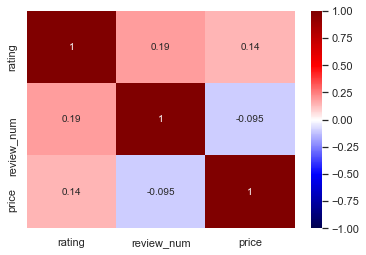

In [89]:
#plt.figure(figsize=(20,10))
sns.heatmap(VideoGames_df3.corr(), cmap='seismic',annot=True,vmin=-1,vmax=1)

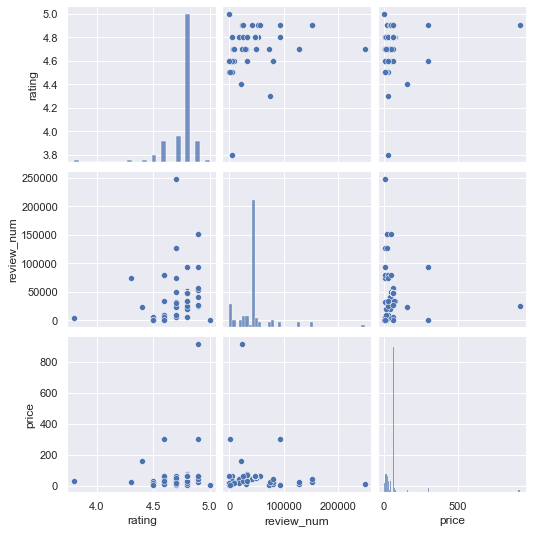

In [90]:
sns.pairplot(VideoGames_df3)

In [91]:
#VideoGames_df3.dropna(inplace = True)

In [92]:
VideoGames_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 49
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   VideoGamesType  100 non-null    object 
 1   company         100 non-null    object 
 2   rating          100 non-null    float64
 3   review_num      100 non-null    float64
 4   price           100 non-null    float64
dtypes: float64(3), object(2)
memory usage: 4.7+ KB


In [93]:
VideoGames_df3.drop(columns=['VideoGamesType'],axis=1,  inplace=True)



In [94]:
X_dummy = pd.get_dummies(VideoGames_df3)
X_dummy

,rating,review_num,price,company_Electronic Arts,company_Microsoft,company_Mojang AB,company_Nintendo,company_Oculus,company_PlayStation,company_Riot Games,company_Roblox,company_Take-Two 2K,company_other
0,4.7,248158.0,10.00,0,0,0,0,0,1,0,0,0,0
1,4.7,127302.0,10.00,0,1,0,0,0,0,0,0,0,0
2,4.7,73481.0,5.00,0,0,0,1,0,0,0,0,0,0
3,4.6,79974.0,10.00,0,0,0,0,0,0,0,1,0,0
4,4.6,79974.0,25.00,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,4.8,47081.0,59.99,0,0,0,0,0,1,0,0,0,0
46,4.8,47081.0,59.99,0,0,0,0,0,1,0,0,0,0
47,4.8,47081.0,59.99,0,0,0,0,0,1,0,0,0,0
48,4.8,47081.0,59.99,0,0,0,0,0,1,0,0,0,0


In [95]:

X_dummy.drop(columns=['company_Roblox','price'],axis=1,  inplace=True)
X_dummy


,rating,review_num,company_Electronic Arts,company_Microsoft,company_Mojang AB,company_Nintendo,company_Oculus,company_PlayStation,company_Riot Games,company_Take-Two 2K,company_other
0,4.7,248158.0,0,0,0,0,0,1,0,0,0
1,4.7,127302.0,0,1,0,0,0,0,0,0,0
2,4.7,73481.0,0,0,0,1,0,0,0,0,0
3,4.6,79974.0,0,0,0,0,0,0,0,0,0
4,4.6,79974.0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
45,4.8,47081.0,0,0,0,0,0,1,0,0,0
46,4.8,47081.0,0,0,0,0,0,1,0,0,0
47,4.8,47081.0,0,0,0,0,0,1,0,0,0
48,4.8,47081.0,0,0,0,0,0,1,0,0,0


In [96]:
y = VideoGames_df3['price']


In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_dummy,y,test_size=0.20, random_state=19)

In [98]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=19)

In [99]:
m = LinearRegression()
x=VideoGames_df[['VideoGamesType','company','rating','review_num']]
y=VideoGames_df[['price']]
m.fit(pd.get_dummies(X_train),y_train)

LinearRegression()

In [100]:
m.score(pd.get_dummies(X_test),y_test)

-6.6216699353858175

In [101]:
m.score(pd.get_dummies(X_val),y_val)

-0.8276704700368103

In [102]:
m.score(pd.get_dummies(X_train),y_train)

0.11904601533181791

In [103]:
preds = m.predict(pd.get_dummies(X_train))

In [104]:
X2 = pd.get_dummies(X_train)
y = y_train

In [105]:
def SSE(actuals, preds):
    return np.sum((actuals - preds)**2)
    
#y = y.to_numpy()    
#
def SST(y):
    return np.sum((y - np.mean(y))**2)

def R2(actuals, preds):
    return 1 - SSE(actuals, preds) / SST(actuals)

def MAE(actuals, preds): #mean absolute error
    return np.mean(np.abs(actuals-preds))

def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((actuals - preds)**2))

y = y.astype('float64')

print ("SSE" , SSE(y,preds) )
print ("RMSE" , RMSE(y,preds))
print ("MAE" , MAE(y,preds))
print ("R2" , R2(y,preds))

SSE 725590.7656372904
RMSE 109.96899302661717
MAE 41.36211704400172
R2 0.11904601533181769


In [106]:
X2.columns

Index(['rating', 'review_num', 'company_Electronic Arts', 'company_Microsoft',
       'company_Mojang AB', 'company_Nintendo', 'company_Oculus',
       'company_PlayStation', 'company_Riot Games', 'company_Take-Two 2K',
       'company_other'],
      dtype='object')

In [107]:
X2.shape

(60, 11)

In [108]:
X_val.shape

(20, 11)

In [109]:
X_test.shape

(20, 11)

In [110]:
selected_columns = ['rating', 'review_num', 'company_Microsoft', 'company_Mojang AB',
       'company_Nintendo', 'company_Oculus', 'company_PlayStation',
       'company_Riot Games', 'company_Take-Two 2K', 'company_other']

In [111]:
X2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 7 to 46
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rating                   60 non-null     float64
 1   review_num               60 non-null     float64
 2   company_Electronic Arts  60 non-null     uint8  
 3   company_Microsoft        60 non-null     uint8  
 4   company_Mojang AB        60 non-null     uint8  
 5   company_Nintendo         60 non-null     uint8  
 6   company_Oculus           60 non-null     uint8  
 7   company_PlayStation      60 non-null     uint8  
 8   company_Riot Games       60 non-null     uint8  
 9   company_Take-Two 2K      60 non-null     uint8  
 10  company_other            60 non-null     uint8  
dtypes: float64(2), uint8(9)
memory usage: 1.9 KB


In [112]:
lasso_model = Lasso(alpha = 1000000) # this is a VERY HIGH regularization strength!, wouldn't usually be used
lasso_model.fit(X2.loc[:,selected_columns], y)

Lasso(alpha=1000000)

In [113]:
list(zip(selected_columns, lasso_model.coef_))

[('rating', 0.0),
 ('review_num', -0.0),
 ('company_Microsoft', -0.0),
 ('company_Mojang AB', 0.0),
 ('company_Nintendo', -0.0),
 ('company_Oculus', 0.0),
 ('company_PlayStation', 0.0),
 ('company_Riot Games', -0.0),
 ('company_Take-Two 2K', -0.0),
 ('company_other', 0.0)]

In [114]:
np.random.seed(6)

X2_collinear = X2.loc[:,selected_columns]
X2_collinear['rating Clone'] = (X2_collinear['rating'] + 
                                      2500 * np.random.randn(X2.shape[0])) # "adding colliniear variable"

X2_collinear.corr()

,rating,review_num,company_Microsoft,company_Mojang AB,company_Nintendo,company_Oculus,company_PlayStation,company_Riot Games,company_Take-Two 2K,company_other,rating Clone
rating,1.000000,0.065200,0.024396,NaN,0.167590,NaN,0.389692,-0.157780,0.200141,-0.532666,0.032863
review_num,0.065200,1.000000,0.121219,NaN,-0.034722,NaN,0.068432,-0.273859,-0.174873,0.010023,0.156858
company_Microsoft,0.024396,0.121219,1.000000,NaN,-0.080582,NaN,-0.382420,-0.069171,-0.039253,-0.100504,0.089335
company_Mojang AB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_Nintendo,0.167590,-0.034722,-0.080582,NaN,1.000000,NaN,-0.338979,-0.061314,-0.034794,-0.089087,-0.153200
company_Oculus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_PlayStation,0.389692,0.068432,-0.382420,NaN,-0.338979,NaN,1.000000,-0.290978,-0.165124,-0.422781,0.047812
company_Riot Games,-0.157780,-0.273859,-0.069171,NaN,-0.061314,NaN,-0.290978,1.000000,-0.029867,-0.076472,0.168741
company_Take-Two 2K,0.200141,-0.174873,-0.039253,NaN,-0.034794,NaN,-0.165124,-0.029867,1.000000,-0.043396,-0.283499
company_other,-0.532666,0.010023,-0.100504,NaN,-0.089087,NaN,-0.422781,-0.076472,-0.043396,1.000000,0.007555


In [115]:
model = sm.OLS(y, sm.add_constant(X2_collinear))
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     1.368
Date:                Sun, 26 Sep 2021   Prob (F-statistic):              0.228
Time:                        18:48:24   Log-Likelihood:                -364.34
No. Observations:                  60   AIC:                             748.7
Df Residuals:                      50   BIC:                             769.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -901.4766    581.814     -1.549      0.128   -2070.085     267.132
rating                209.3436    126.900      1.650      0.105     -45.542     464.229
review_num             -0.0005      0.000     -1.232      0.224      -0.001       0.000
company_Microsoft     -52.9103     80.587     -0.657      0.514    -214.774     108.953
company_Mojang AB    1.327e-14   7.38e-14      0.180      0.858   -1.35e-13    1.62e-13
company_Nintendo      -13.5511     89.561     -0.151      0.880    -193.439     166.337
company_Oculus       5.692e-15   3.68e-14      0.155      0.878   -6.83e-14    7.97e-14
company_PlayStation    -0.1341     66.934     -0.002      0.998    -134.575     134.307
company_Riot Games    -77.1231     93.208     -0.827      0.412    -264.337     110.091
company_Take-Two 2K   -68.4749    147.616     -0.464      0.645    -364.971     228.021
company_other          51.6276     75.389      0.685      0.497     -99.795     203.050
rating Clone            0.0141      0.006      2.224      0.031       0.001       0.027
==============================================================================
Omnibus:                      112.389   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4028.619
Skew:                           5.824   Prob(JB):                         0.00
Kurtosis:                      41.416   Cond. No.                     5.56e+23
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.17e-37. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [116]:
lr_model_ridge = Ridge(alpha = 1000000000000)
lr_model_ridge.fit(X2_collinear, y)

list(zip(X2_collinear.columns, lr_model_ridge.coef_))

[('rating', 2.584063397709606e-10),
 ('review_num', -1.4664738580600361e-05),
 ('company_Microsoft', -2.092463323125819e-10),
 ('company_Mojang AB', 0.0),
 ('company_Nintendo', -2.0410070874421698e-11),
 ('company_Oculus', 0.0),
 ('company_PlayStation', 5.930201163519826e-10),
 ('company_Riot Games', -1.3702893454700522e-10),
 ('company_Take-Two 2K', -6.372633848976556e-11),
 ('company_other', 1.1857148981384773e-11),
 ('rating Clone', 5.228136111372861e-06)]

In [117]:
lr_model_lasso = Lasso(alpha = 100000)
lr_model_lasso.fit(X2_collinear, y)

list(zip(X2_collinear.columns, lr_model_lasso.coef_))

[('rating', 0.0),
 ('review_num', -0.00012430082233958611),
 ('company_Microsoft', -0.0),
 ('company_Mojang AB', 0.0),
 ('company_Nintendo', -0.0),
 ('company_Oculus', 0.0),
 ('company_PlayStation', 0.0),
 ('company_Riot Games', -0.0),
 ('company_Take-Two 2K', -0.0),
 ('company_other', 0.0),
 ('rating Clone', 0.0)]

In [118]:
test_set_pred = lasso_model.predict(X_test.loc[:,selected_columns])

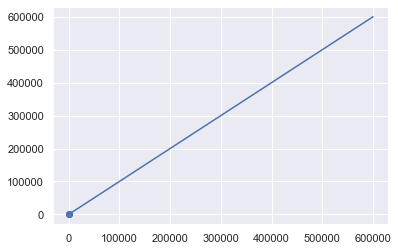

In [119]:
plt.scatter(test_set_pred, y_test, alpha=.1)
plt.plot(np.linspace(0,600000,1000), np.linspace(0,600000,1000))

In [120]:
r2_score(y_test, test_set_pred)

-0.8907526953097089

In [121]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

mae(y_test, test_set_pred)

16.915166666666643

In [122]:
## This step fits the Standard Scaler to the training data
## Essentially it finds the mean and standard deviation of each variable in the training set

std = StandardScaler()
std.fit(X2.values)

StandardScaler()

In [123]:
## This step applies the scaler to the train set.
## It subtracts the mean it learned in the previous step and then divides by the standard deviation

X_tr = std.transform(X2.values)

In [124]:
## Apply the scaler to the test set

X_te = std.transform(X_test.values)

(array([55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  5.]),
 array([-0.30151134,  0.06030227,  0.42211588,  0.7839295 ,  1.14574311,
         1.50755672,  1.86937034,  2.23118395,  2.59299756,  2.95481118,
         3.31662479]),
 <BarContainer object of 10 artists>)

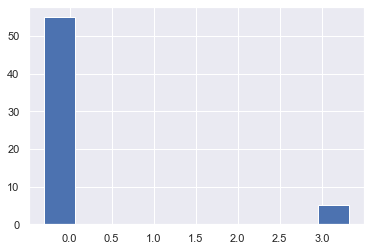

In [125]:
## Here we can plot histograms of the transformed variables
## Note that they seem to have means of 0 and stddevs of 1
## (though they are not necessarily normally distributed)

plt.hist(X_tr[:,3])

In [126]:
lasso_model = Lasso(alpha = 10000)
lasso_model.fit(X_tr,y)

Lasso(alpha=10000)

In [127]:
## Note that now we can meaningful compare the importance of
## different features, since they're on the same scale

## But it's now difficult to interpret the coefficients
## We would need to translate back to the original feature scales by dividing
## each coefficient by the original column's standard deviation

list(zip(X2.columns, lasso_model.coef_))

[('rating', 0.0),
 ('review_num', -0.0),
 ('company_Electronic Arts', -0.0),
 ('company_Microsoft', -0.0),
 ('company_Mojang AB', 0.0),
 ('company_Nintendo', -0.0),
 ('company_Oculus', 0.0),
 ('company_PlayStation', 0.0),
 ('company_Riot Games', -0.0),
 ('company_Take-Two 2K', -0.0),
 ('company_other', 0.0)]

In [128]:
alphalist = 10**(np.linspace(-2,2,200))
err_vec_val = np.zeros(len(alphalist))
#err_vec_train = np.zeros(len(alphalist))

for i,curr_alpha in enumerate(alphalist):

    # note the use of a new sklearn utility: Pipeline to pack
    # multiple modeling steps into one fitting process 
    steps = [('standardize', StandardScaler()), 
             ('lasso', Lasso(alpha = curr_alpha))] # "curr_alpha is the loop counter"

    pipe = Pipeline(steps) # "pipe the steps using Pipeline package"
    pipe.fit(X2.loc[:,selected_columns].values, y)
    
    val_set_pred = pipe.predict(X_val.loc[:,selected_columns].values)
    err_vec_val[i] = mae(y_val, val_set_pred) # "i used for storing"

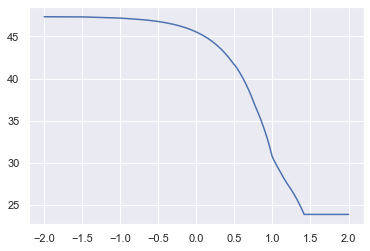

In [129]:
#plot the curve of validation error as alpha changes

plt.plot(np.log10(alphalist), err_vec_val)

In [130]:
## This is the minimum error achieved on the validation set 
## across the different alpha values we tried

np.min(err_vec_val)

23.88131666666665

In [131]:
## This is the value of alpha that gave us the lowest error
alphalist[np.argmin(err_vec_val)] # "this result is diffrent from the graph as we are using log scale in the graph"

26.126752255633292

In [132]:
## Scale the data as before
std = StandardScaler()
std.fit(X2.values)

StandardScaler()

In [133]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [134]:
lasso_model.alpha_

16.446761779946645

In [135]:
list(zip(X2.columns, lasso_model.coef_))

[('rating', 9.615598603304846),
 ('review_num', -0.0),
 ('company_Electronic Arts', -0.0),
 ('company_Microsoft', -0.0),
 ('company_Mojang AB', 0.0),
 ('company_Nintendo', -0.0),
 ('company_Oculus', 0.0),
 ('company_PlayStation', 0.09882565654526729),
 ('company_Riot Games', -0.0),
 ('company_Take-Two 2K', -0.0),
 ('company_other', 0.0)]

In [136]:
test_set_pred = lasso_model.predict(X_te)

In [137]:
mae(y_test, test_set_pred)

18.596875633386645

In [138]:
r2_score(y_test, test_set_pred)

-0.9104949095553183

In [139]:
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y.values, method='lasso')

Computing regularization path using the LARS ...


In [140]:
print(alphas)
print(_)

[26.10075745 16.58417203 11.63962184 10.43746766  9.96672601  8.82447861
  4.81988911  3.27609032  2.01315147  0.88390579  0.24154465  0.        ]
[0, 3, 9, 10, 1, 8, 5, 2, 7]


[  0.           9.51658542  16.63262547  19.1723691   20.91226693
  29.13882847  65.98826906  81.08476559  98.16428499 116.45045607
 124.6631862  138.77487907]
[0.         0.06857571 0.11985329 0.13815446 0.15069202 0.20997192
 0.47550587 0.58428994 0.70736351 0.8391321  0.89831234 1.        ]


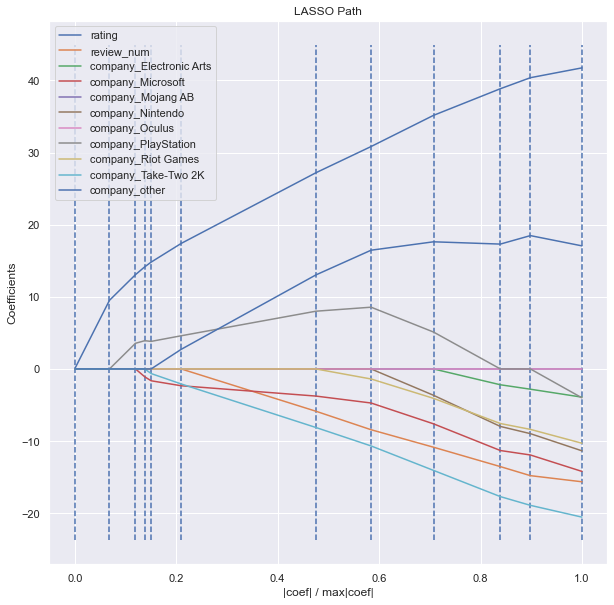

In [141]:
xx = np.sum(np.abs(coefs.T), axis=1) # "after transposing coefs, this is the sum of the coeffcients for each value of lambda"
print(xx)
xx /= xx[-1] # "divid by the last "
print(xx)
plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T) # "plots the sum of the coeffcients scaled byt the maximum with the coeffcients "
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X2.columns)
plt.show()

In [142]:
coefs.shape

(11, 12)

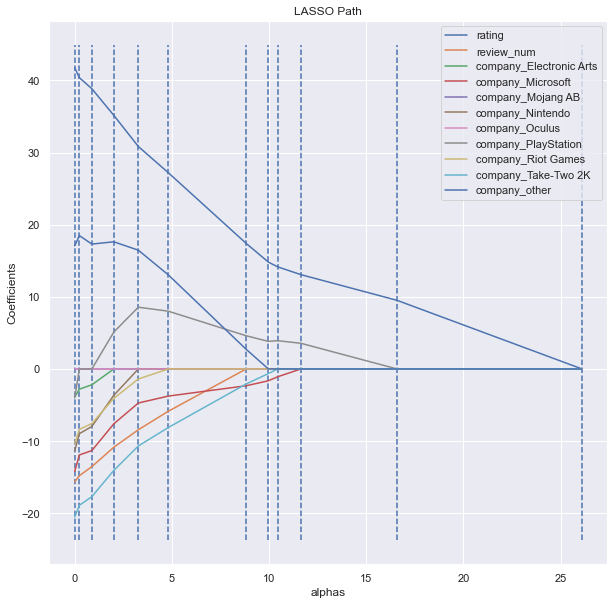

In [143]:
plt.figure(figsize=(10,10))
plt.plot(alphas, coefs.T) # "plots the sum of the coeffcients scaled byt the maximum with the coeffcients "
ymin, ymax = plt.ylim()
plt.vlines(alphas, ymin, ymax, linestyle='dashed')
plt.xlabel('alphas')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X2.columns)
plt.show()

In [144]:
def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x) # "regression prediction"

    plt.subplot(1, 3, 1)
    plt.scatter(x,y) # "scatter"
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res) # "scatter supposed to have no pattern"
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt) # "normal qq plot"
    plt.title("Normal Q-Q plot")

In [145]:
# Generate fake data
s = 500
x = np.random.uniform(low=-5, high=5, size=s)

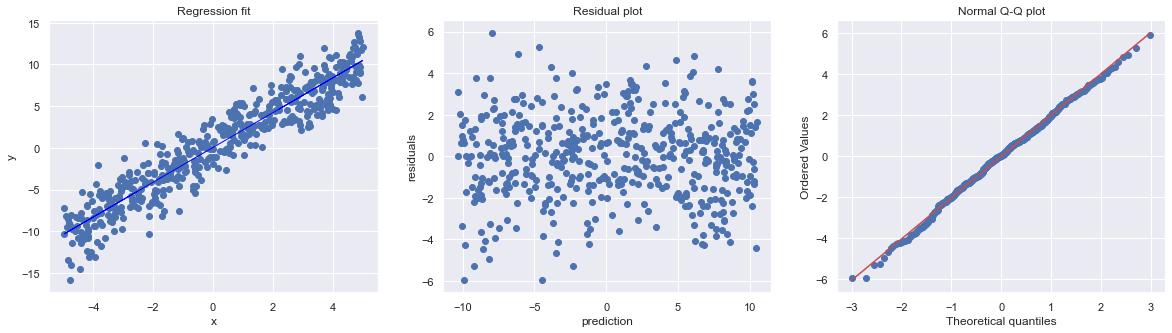

In [146]:
epsilon = 2*np.random.randn(s)
beta = 2
y = beta*x + epsilon

diagnostic_plot(x.reshape(s,1), y) # we reshape x to turn it into a tall column

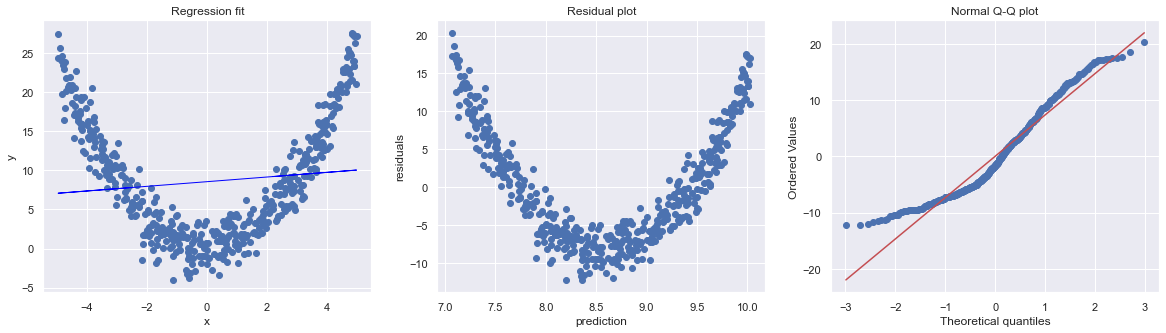

In [147]:
#Diagnose
beta1 = 1
y = beta1*(x**2) + epsilon

diagnostic_plot(x.reshape(s,1), y)

In [148]:
VideoGames_df3.describe()

,rating,review_num,price
count,100.000000,100.000000,100.000000
mean,4.754000,47209.480000,63.489800
std,0.144544,33988.636307,95.428732
min,3.800000,1.000000,1.990000
25%,4.700000,33190.750000,41.490000
50%,4.800000,47081.000000,59.990000
75%,4.800000,47081.000000,59.990000
max,5.000000,248158.000000,915.460000


In [149]:
# remove non-numeric data
cols = ['review_num']
X = VideoGames_df3[cols]
y = VideoGames_df3.price   # predictor

In [150]:
# develop OLS with Sklearn
lr = LinearRegression()
fit = lr.fit(X,y) # for later use

In [151]:
X = VideoGames_df3[['rating','review_num']]
y = VideoGames_df3.price

model = sm.OLS(y,X) # "from stats package"
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.320
Model:                            OLS   Adj. R-squared (uncentered):              0.306
Method:                 Least Squares   F-statistic:                              23.09
Date:                Sun, 26 Sep 2021   Prob (F-statistic):                    6.07e-09
Time:                        18:48:39   Log-Likelihood:                         -596.40
No. Observations:                 100   AIC:                                      1197.
Df Residuals:                      98   BIC:                                      1202.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
rating        16.3831      3.460      4.735      0.000       9.517      23.249
review_num    -0.0003      0.000     -1.046      0.298      -0.001       0.000
==============================================================================
Omnibus:                      184.107   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16930.811
Skew:                           7.457   Prob(JB):                         0.00
Kurtosis:                      64.975   Cond. No.                     2.11e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 2.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


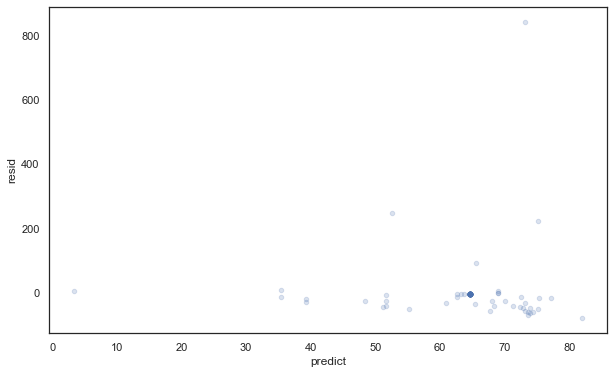

In [152]:
# Plot your predicted values on the x-axis, and your residuals on the y-axis

VideoGames_df3['predict']=fit.predict(X)
VideoGames_df3['resid']=VideoGames_df3.price-VideoGames_df3.predict # "residuals"
with sns.axes_style('white'):
    plot=VideoGames_df3.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

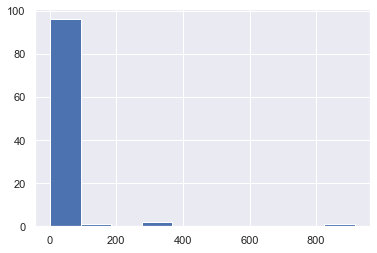

In [153]:
VideoGames_df3.price.hist();

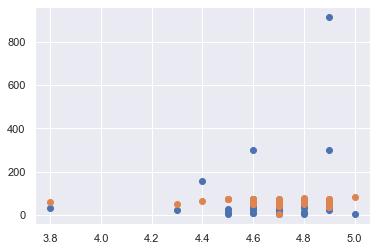

In [154]:
plt.scatter(VideoGames_df3.rating,y)
plt.scatter(VideoGames_df3.rating,VideoGames_df3.predict);

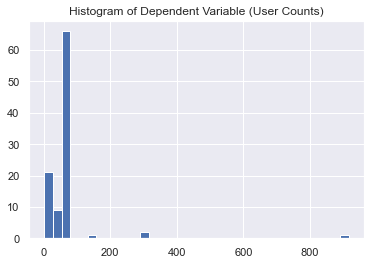

In [155]:
VideoGames_df3.price.hist(bins=35)
plt.title('Histogram of Dependent Variable (User Counts)');

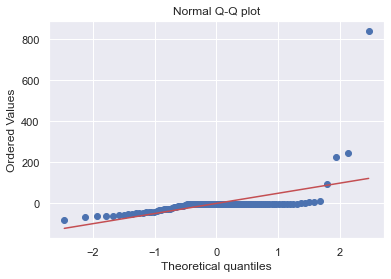

In [156]:
# diagnose/inspect residual normality using qqplot:
stats.probplot(VideoGames_df3['resid'], dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

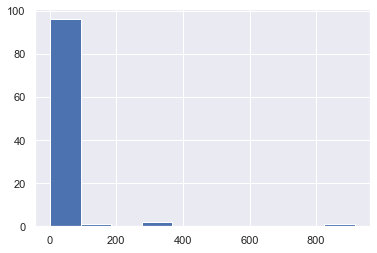

In [157]:
VideoGames_df3.price.hist();


Lambda: 0.03916280110382988


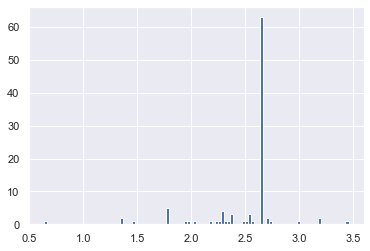

In [158]:
#lambda
lamb=stats.boxcox_normmax(VideoGames_df3.price, brack=(-1.9, 1.9)) # "Compute optimal Box-Cox transform parameter for input data, brack for intilization"
print("Lambda:", lamb)
y_t=(np.power(VideoGames_df3.price,-0.2282)-1)/-0.2282 # "the value of lambda is choosen from the box cox normality plot"

plt.hist(y_t,bins=100);

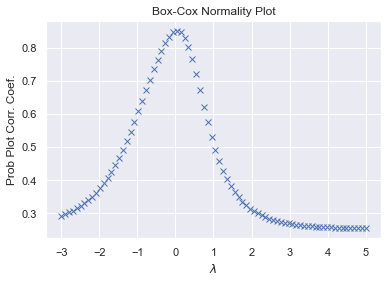

In [159]:
#after function on lambda
fig = plt.figure()
ax = fig.add_subplot(111)
prob = stats.boxcox_normplot(VideoGames_df3.price, -3, 5, plot=ax)